# (unsorted) Rotating MNIST
Diagonal online Laplace with a replay buffer v.s. diagonal LoFi

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
kmode = "valid"
ksize = 50
kernel = np.ones(ksize) / ksize

## Hyperparameter optimisation

In [ ]:
%%time
%run rotating_mnist_unsorted.py

Training RSGD
|   iter    |  target   |  log_lr   |
-------------------------------------
| 1         | -5.601e+0 | -11.38    |
| 2         | -3.757e+0 | -9.025    |
| 3         | -1e+10    | -7.787    |
| 4         | -6.635e+0 | -14.96    |
| 5         | -6.087e+0 | -14.28    |


## Building agent

In [6]:
lr = np.exp(optimiser_rsgd.max["params"]["log_lr"])
tx = optax.sgd(lr)

agent_rsgd = rsgd.init_regression_agent(
    key, part_log_likelihood, model, X_train, tx, memory_size,
    lossfn=part_lossfn,
    prior_precision=1 / initial_covariance,
)

In [7]:
lr = np.exp(optimiser_rsgd_adam.max["params"]["log_lr"])
tx = optax.adam(lr)

agent_rsgd_adam = rsgd.init_regression_agent(
    key, part_log_likelihood, model, X_train, tx, memory_size,
    lossfn=part_lossfn,
    prior_precision=1 / initial_covariance,
)

In [8]:
dynamics_covariance = np.exp(optimiser_lofi.max["params"]["log_dynamics_covariance"])
dynamics_weights = 1 - np.exp(optimiser_lofi.max["params"]["log_1m_dynamics_weights"])

agent_lofi, rfn = lofi.init_regression_agent(
    key, model, X_train,
    initial_covariance, dynamics_weights, dynamics_covariance,
    emission_cov, memory_size
)

## Run agents

In [9]:
callback = partial(callbacks.cb_reg_mc,
                ymean=ymean, ystd=ystd,
                X_test=X_train, y_test=Y_train,
                key=key,
)

In [82]:
callback_rsgd_adam = partial(callback, apply_fn=agent_rsgd_adam.apply_fn, agent=agent_rsgd_adam)
bel_rsgd_adam, output_rsgd_adam = agent_rsgd_adam.scan(X_test, Y_test, progress_bar=True, callback=callback_rsgd_adam)
output_rsgd_adam = tree_to_cpu(output_rsgd_adam)

  0%|          | 0/1032 [00:00<?, ?it/s]

In [83]:
callback_rsgd = partial(callback, apply_fn=agent_rsgd.apply_fn, agent=agent_rsgd)
bel_rsgd, output_rsgd = agent_rsgd.scan(X_test, Y_test, progress_bar=True, callback=callback_rsgd)
output_rsgd = tree_to_cpu(output_rsgd)

  0%|          | 0/1032 [00:00<?, ?it/s]

In [84]:
callback_lofi = partial(callback, apply_fn=agent_lofi.params.emission_mean_function, agent=agent_lofi)
bel_lofi, output_lofi = agent_lofi.scan(X_test, Y_test, progress_bar=True, callback=callback_lofi)
output_lofi = tree_to_cpu(output_lofi)

  0%|          | 0/1032 [00:00<?, ?it/s]

## Plot results

In [85]:
dir_output = "../../figures/"
task_name = "iid-rotation"

### RMSE

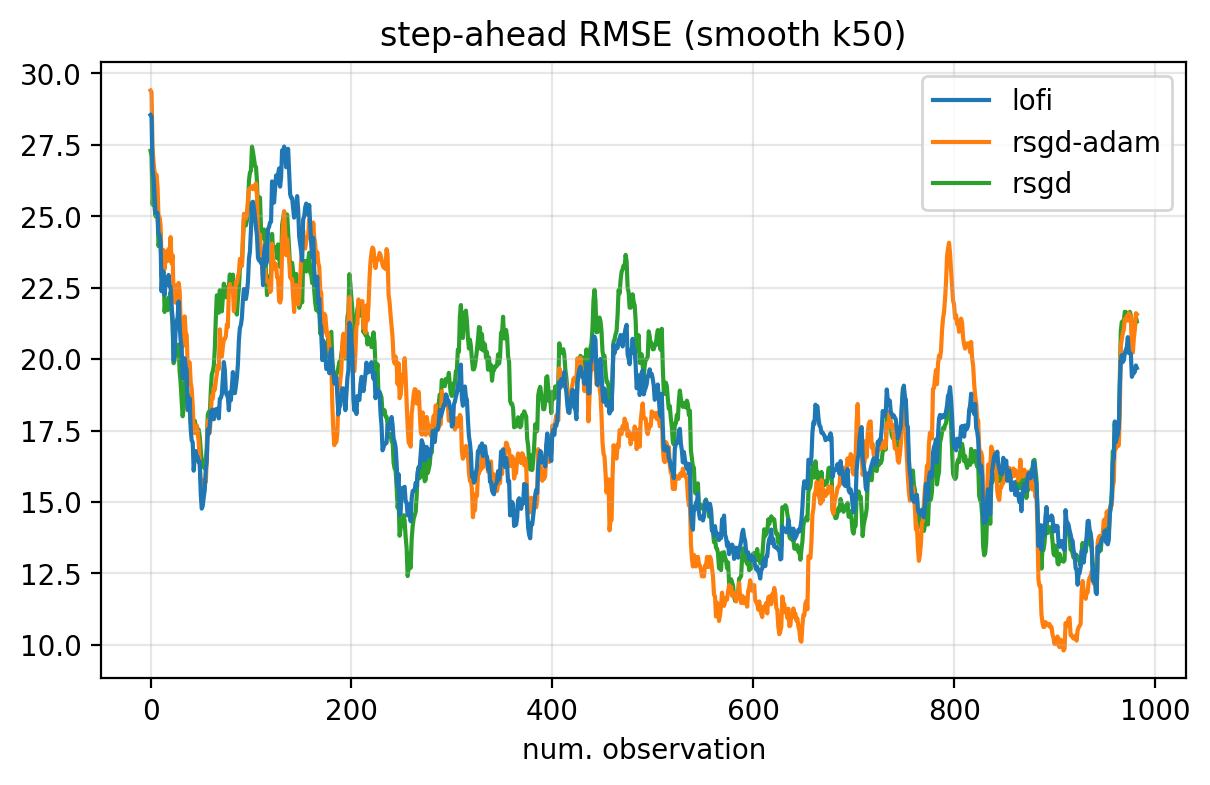

In [89]:
fig, ax = plt.subplots(figsize=(7, 4))

err_smooth_lofi = output_lofi["osa-metric"]
err_smooth_rsgd_adam = output_rsgd_adam["osa-metric"]
err_smooth_rsgd = output_rsgd["osa-metric"]

err_smooth_lofi = np.convolve(err_smooth_lofi, kernel, mode=kmode)
err_smooth_rsgd_adam = np.convolve(err_smooth_rsgd_adam, kernel, mode=kmode)
err_smooth_rsgd = np.convolve(err_smooth_rsgd, kernel, mode=kmode)

plt.plot(err_smooth_lofi, label="lofi", zorder=2)
plt.plot(err_smooth_rsgd_adam, label="rsgd-adam", zorder=1)
plt.plot(err_smooth_rsgd, label="rsgd", zorder=0)

plt.grid(alpha=0.3)

vmin = np.quantile(err_smooth_rsgd_adam, 0.00)
vmax = np.quantile(err_smooth_rsgd_adam, 0.99)
plt.legend()
plt.title(f"step-ahead RMSE (smooth k{ksize})")
plt.xlabel("num. observation")

namefile = "ose-rmse.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)
# plt.ylim(vmin, vmax);

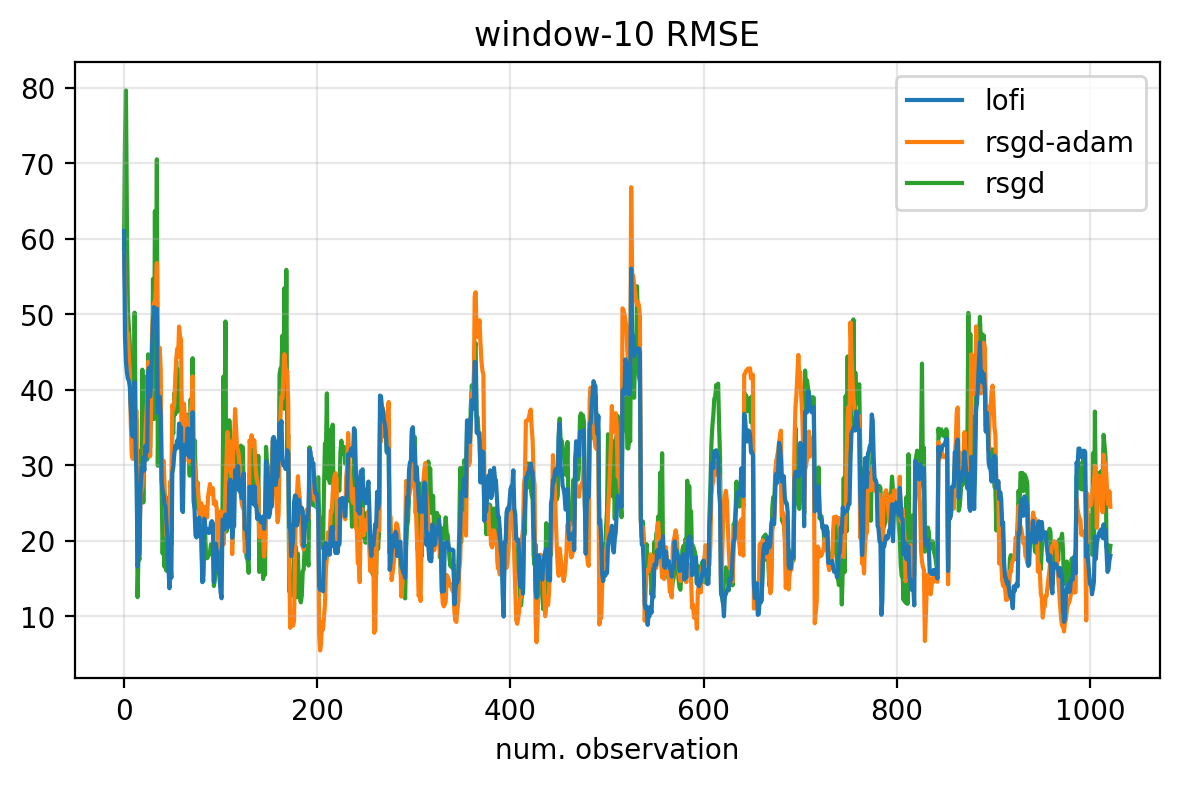

In [90]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_rsgd_adam = output_rsgd_adam["window-metric"]
metric_rsgd = output_rsgd["window-metric"]
metric_lofi = output_lofi["window-metric"]

plt.plot(metric_lofi[10:], label="lofi", zorder=2)
plt.plot(metric_rsgd_adam[10:], label="rsgd-adam", zorder=1)
plt.plot(metric_rsgd[10:], label="rsgd", zorder=0)

plt.grid(alpha=0.3)

vmin = np.quantile(metric_lofi[20:], 0.00)
vmax = np.quantile(metric_rsgd[20:], 0.99)
plt.legend()
plt.title("window-10 RMSE")
plt.xlabel("num. observation")

namefile = "window-rmse.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)
# plt.ylim(vmin, vmax);

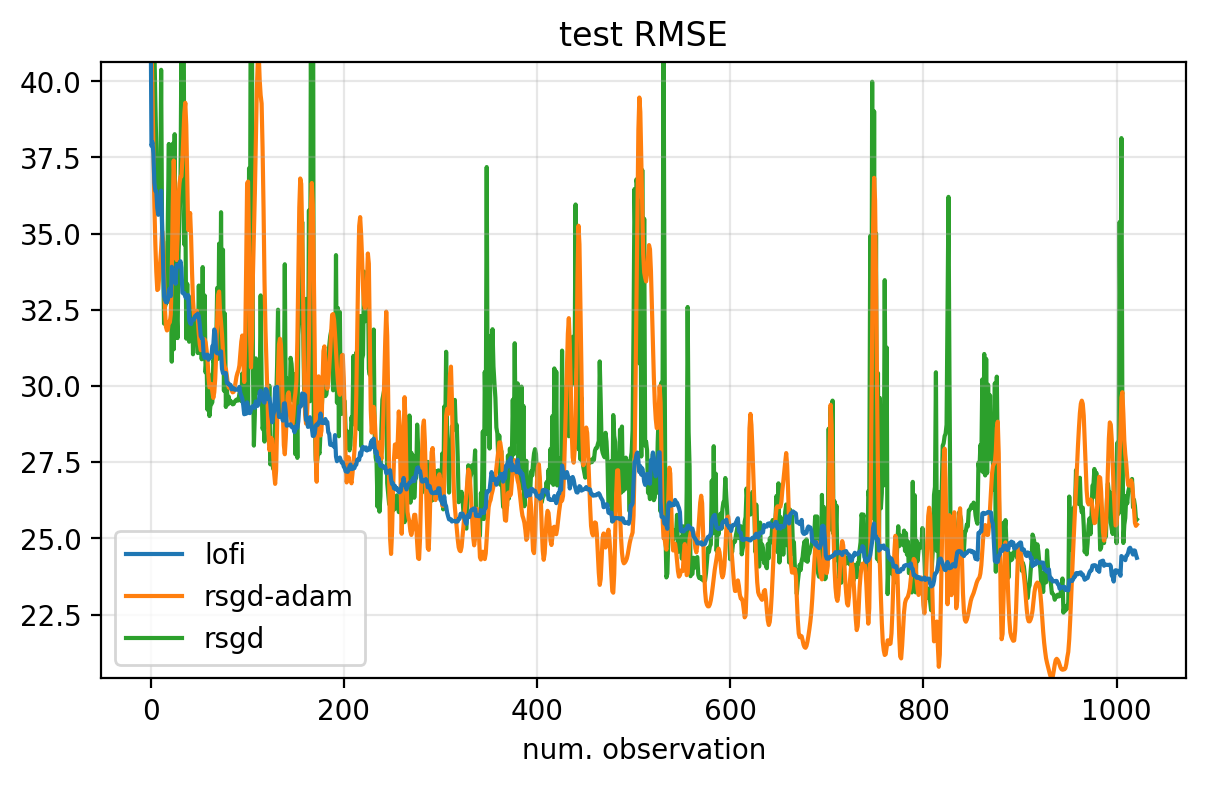

In [130]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_rsgd_adam = output_rsgd_adam["test-metric"]
metric_rsgd = output_rsgd["test-metric"]
metric_lofi = output_lofi["test-metric"]

plt.plot(metric_lofi[10:], label="lofi", zorder=2)
plt.plot(metric_rsgd_adam[10:], label="rsgd-adam", zorder=1)
plt.plot(metric_rsgd[10:], label="rsgd", zorder=0)

plt.grid(alpha=0.3)

plt.legend()
plt.title("test RMSE")
plt.xlabel("num. observation")

namefile = "test-rmse.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")

vmin = np.quantile(metric_rsgd_adam[20:], 0.00)
vmax = np.quantile(metric_rsgd_adam[20:], 0.999)

plt.ylim(vmin, vmax);
plt.savefig(namefile)

### NLPD

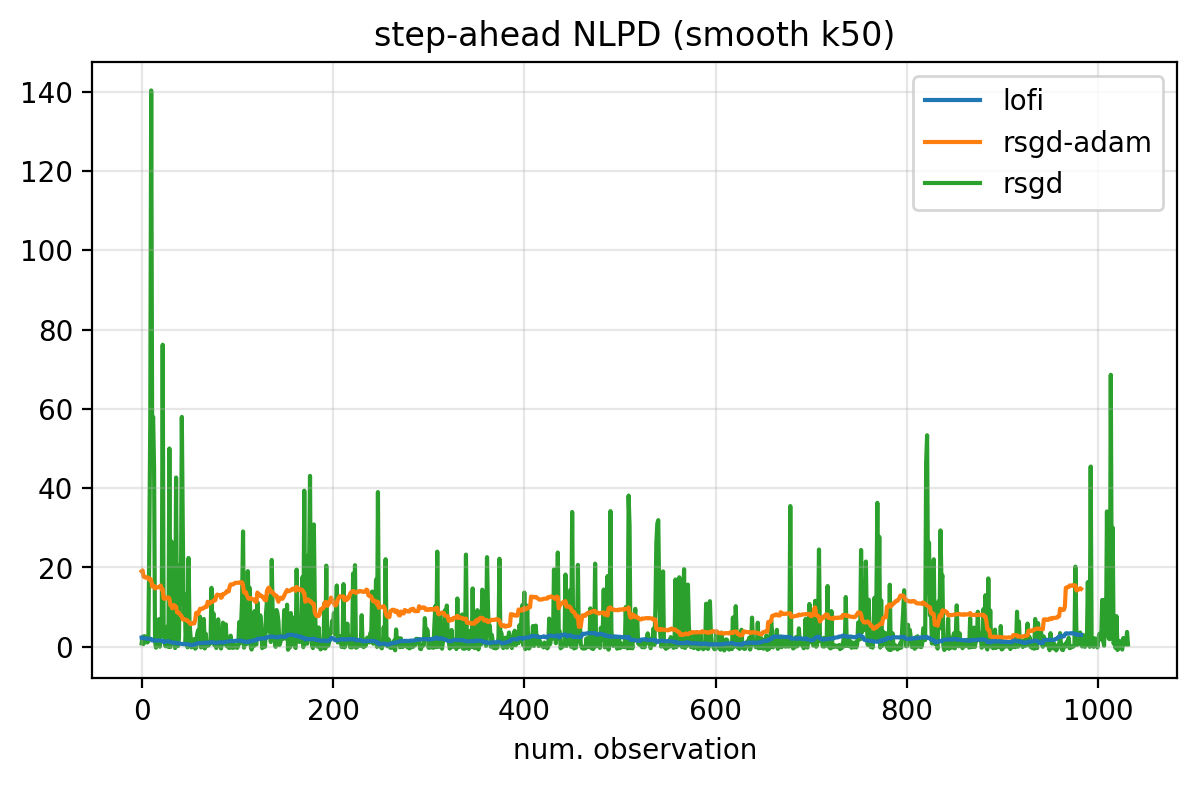

In [123]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_lofi = output_lofi["nlpd"]
metric_rsgd_adam = output_rsgd_adam["nlpd"]
metric_rsgd = output_rsgd["nlpd"]

metric_lofi = np.convolve(metric_lofi, kernel, mode=kmode)
metric_rsgd_adam = np.convolve(metric_rsgd_adam, kernel, mode=kmode)

plt.plot(metric_lofi, label="lofi", zorder=2)
plt.plot(metric_rsgd_adam, label="rsgd-adam", zorder=1)
plt.plot(metric_rsgd, label="rsgd", zorder=0)

plt.title(f"step-ahead NLPD (smooth k{ksize})")
plt.xlabel("num. observation")

plt.legend()
plt.grid(alpha=0.3)

namefile = "ose-nlpd.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

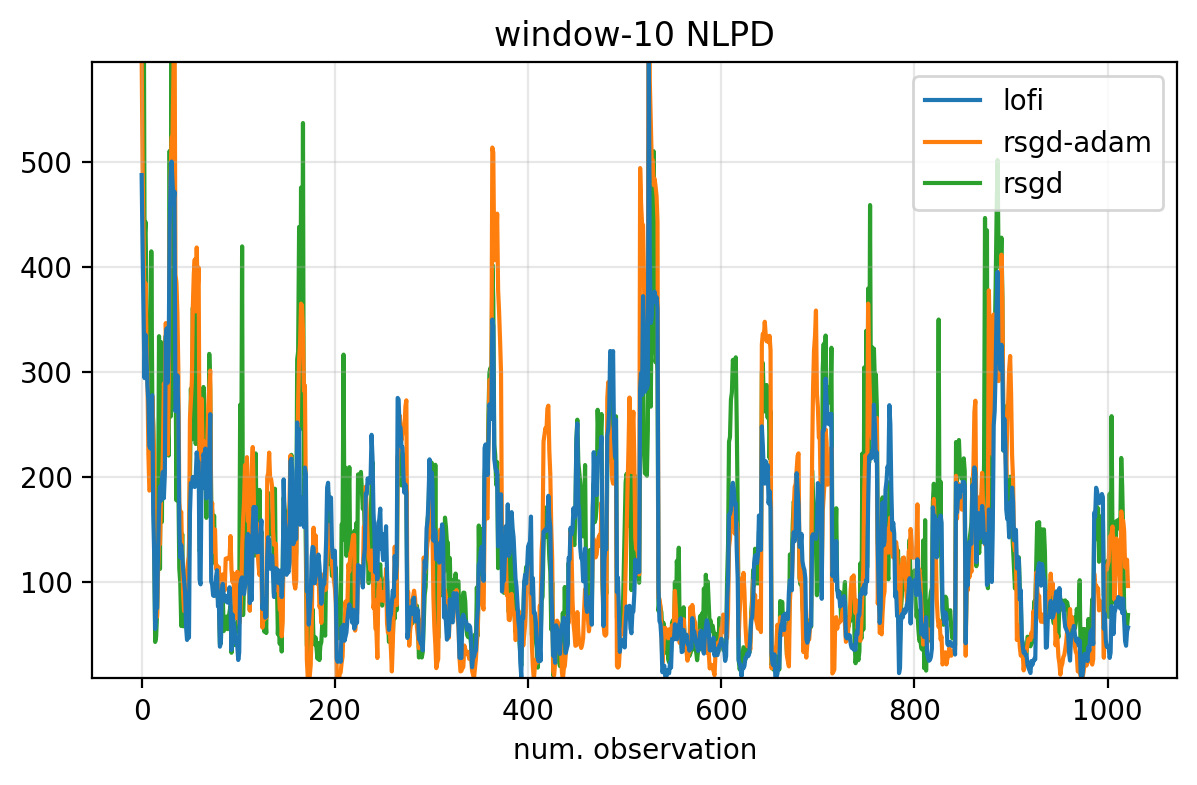

In [124]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_lofi = output_lofi["nlpd_window"]
metric_rsgd_adam = output_rsgd_adam["nlpd_window"]
metric_rsgd = output_rsgd["nlpd_window"]

plt.plot(metric_lofi[10:], label="lofi", zorder=2)
plt.plot(metric_rsgd_adam[10:], label="rsgd-adam", zorder=1)
plt.plot(metric_rsgd[10:], label="rsgd", zorder=0)

plt.grid(alpha=0.3)

plt.legend()
plt.title("window-10 NLPD")
plt.xlabel("num. observation")

vmin = np.quantile(metric_lofi[100:], 0.00)
vmax = np.quantile(metric_rsgd_adam[100:], 0.999)
plt.ylim(vmin, vmax)

namefile = "window-nlpd.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

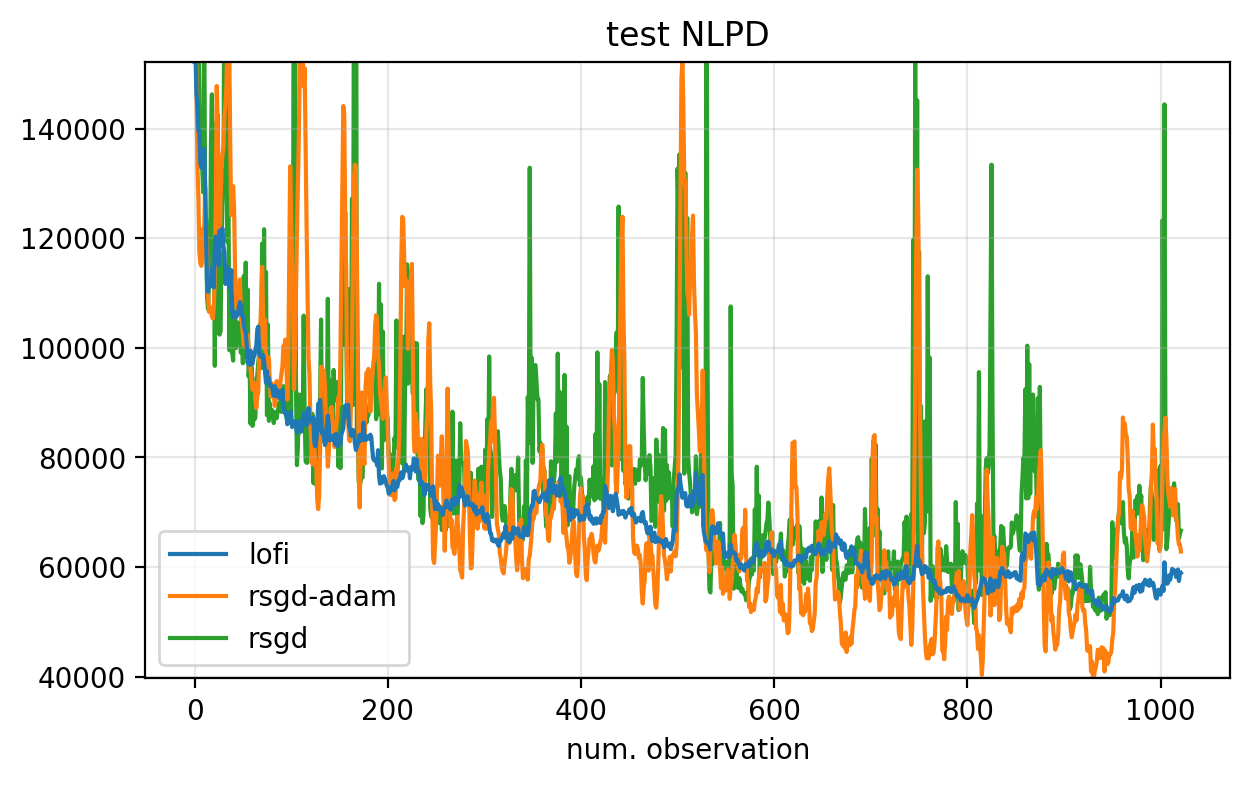

In [126]:
fig, ax = plt.subplots(figsize=(7, 4))

metric_lofi = output_lofi["nlpd_test"]
metric_rsgd_adam = output_rsgd_adam["nlpd_test"]
metric_rsgd = output_rsgd["nlpd_test"]

plt.plot(metric_lofi[10:], label="lofi", zorder=2)
plt.plot(metric_rsgd_adam[10:], label="rsgd-adam", zorder=1)
plt.plot(metric_rsgd[10:], label="rsgd", zorder=0)

plt.grid(alpha=0.3)

plt.legend()
plt.title("test NLPD")
plt.xlabel("num. observation")

vmin = np.quantile(metric_rsgd_adam[10:], 0.00)
vmax = np.quantile(metric_lofi[10:], 0.999)
# vmin, _ = plt.ylim() 
plt.ylim(vmin, vmax)

namefile = "test-nlpd.pdf"
namefile = os.path.join(dir_output, f"{task_name}-{namefile}")
plt.savefig(namefile)

In [97]:
ytest = Y_test * ystd + ymean
yhattest_lofi = agent_lofi.params.emission_mean_function(bel_lofi.mean, X_test).ravel() * ystd + ymean
yhattest_rsgd_adam = agent_rsgd_adam.apply_fn(bel_rsgd_adam.mean, X_test).ravel() * ystd + ymean
yhattest_rsgd = agent_rsgd.apply_fn(bel_rsgd.mean, X_test).ravel() * ystd + ymean

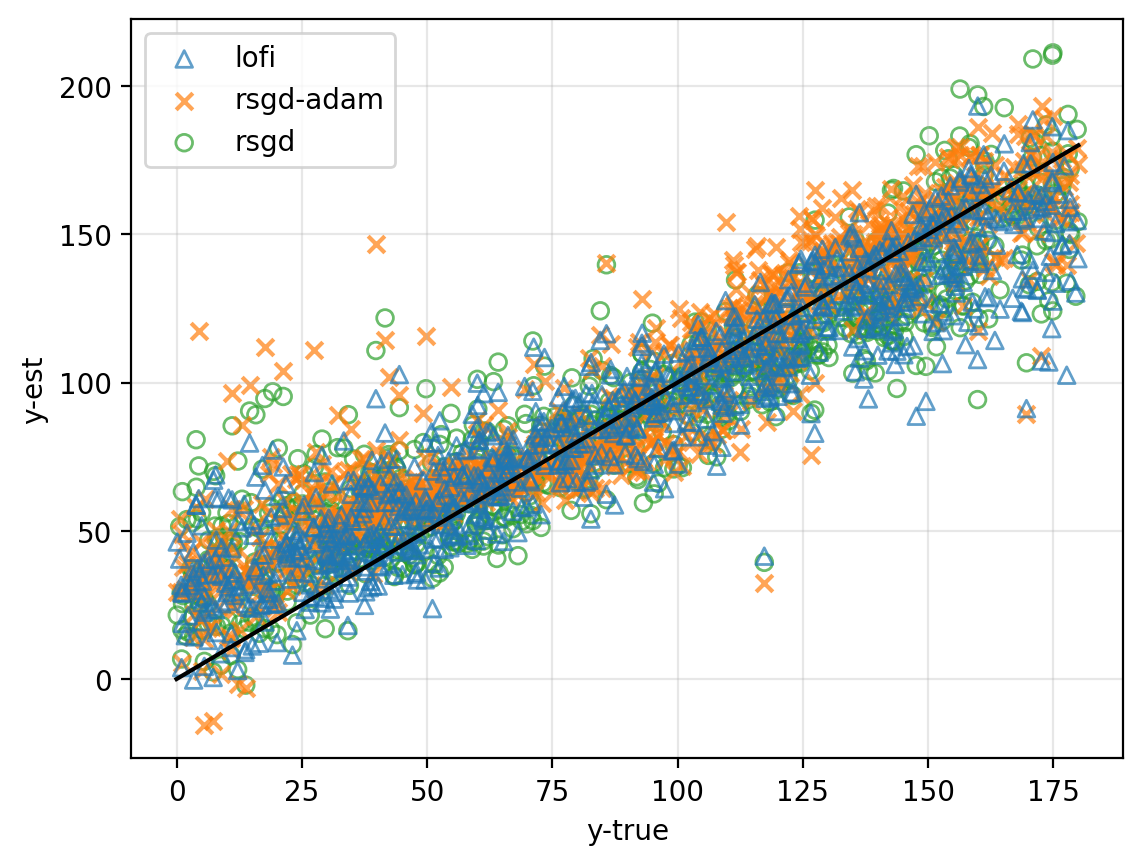

In [109]:
plt.scatter(ytest, yhattest_lofi, label="lofi", alpha=0.7, marker="^", zorder=2, facecolors="none", edgecolors="tab:blue")
plt.scatter(ytest, yhattest_rsgd_adam, label="rsgd-adam", alpha=0.7, marker="x", zorder=1, c="tab:orange")
plt.scatter(ytest, yhattest_rsgd, label="rsgd", alpha=0.7, marker="o", zorder=0, facecolors="none", edgecolors="tab:green")
plt.xlabel("y-true")
plt.ylabel("y-est")
plt.legend()
plt.plot([0,180], [0, 180], c="black")
plt.grid(alpha=0.3)